### I have prepared a powerpoint presentation to accompany this notebook!
**[Capstone_CheckIn_Two_Presentation_Deck](https://docs.google.com/presentation/d/15gWI2tL7TqFVT4-EChSj-5ZYo7z3j6zQjS19Mk5Uzwk/edit?usp=sharing)**

## PROBLEM & GOAL

**PREDICTING FUTURE PLANE PRICES BY MARKET/ROUTE & MONTH (USA)**  

Often we are limited by the scope of our mind to determine travel destinations.  For instance, we pick a vacation destination we have knowledge about or a place our friends have visited, and then look into ways of executing that specific plan.  We end up spending  a significant amount of time fitting these plans to our budget.
  
But there are many other options.  Wouldn’t it be amazing to predict the highest value flights based on your specific budget and time window?
Our product aims to bring transparency into potential vacation destinations and offer an opportunity to identify a travel destination you may not have previously considered while adhering to your budget and time constraints.


## DATA & POTENTIAL FEATURES

**DATA**
- Monthly Historical Jet Fuel Prices [Apr-1990 - Aug-2020]
- Monthly Top 100 Domestic Markets by Carrier [Jan-1990 - Aug-2019]
- Monthly US Domestic Flights [Jan-1990 - Dec-2009]
- Quarterly Top 1,000 Contiguous State City-Pair Markets [Q1-1996 - Q3-2019]

**FEATURES**
- Number of flights
- Number of passengers
- Average plane fare
- Routes / Markets
- Distance
- Airline
- Flight Type 
- freight, mail, passenger, hybrid
- Average plane fare
- Demand



## METHODS / MODELS & EVALUATION

**METHODS / MODELS**
- Linear Time Series Modeling
- Mutlivariate Time Series Modeling (VAR)
- Seasonal / ARIMA Modeling
- SGD Regression

**Evaluation**
- Predicting Future Airline Prices by Market / Month
- Benchmark R2 - 20% increase over baseline model
- Benchmark MSE, RMSE

## RISKS & ASSUMPTIONS

- It may not work!  As we learned yesterday time series data is very difficult and past performance does not dictate future behavior always
- Bias - Plane pricing fluctuates daily dependent on a number of factors, and each carrier has a different pricing model
- More Data may be needed

In [2]:
# imports
import pandas as pd
import requests
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import seaborn as sns

#### DATA:

### Import Dataset #1 - [Historical Jet Fuel Data](https://www.eia.gov/opendata/qb.php?sdid=PET.EER_EPJK_PF4_RGC_DPG.M)

##### by YEAR, QUARTER, MONTH

|variable|description|
| - | - |
|month_year | - |
|jet_fuel_price_per_gallon_usd | - |
|year | - |
|month_abr | - |
|month | - |
|quarter | - |
|year-quarter | - |



In [3]:
# https://stackoverflow.com/questions/20637439/skip-rows-during-csv-import-pandas

fuel = pd.read_csv('./data_final_checkin_2/U.S._Gulf_Coast_Kerosene-Type_Jet_Fuel_Spot_Price_FOB_Monthly.csv', skiprows=4).rename(columns={'Month' : 'month_year', 'Series ID: PET.EER_EPJK_PF4_RGC_DPG.M Dollars per Gallon' : 'jet_fuel_price_per_gallon_usd'})
print(fuel.shape)
fuel.head()


(365, 2)


,month_year,jet_fuel_price_per_gallon_usd
0,Aug 2020,1.112
1,Jul 2020,1.084
2,Jun 2020,0.983
3,May 2020,0.686
4,Apr 2020,0.606


In [4]:
# Create Year & Month Column
fuel['year'] = fuel['month_year'].apply(lambda x: int(x[4:8]))
fuel['month'] = fuel['month_year'].apply(lambda x: x[0:3]).map({'Jan' : 1, 'Feb' : 2, 'Mar' : 3, 'Apr' : 4, 'May' : 5, 'Jun' : 6, 'Jul' : 7, 'Aug' : 8, 'Sep' : 9, 'Oct' : 10, 'Nov' : 11, 'Dec' : 12})
fuel.head()

,month_year,jet_fuel_price_per_gallon_usd,year,month
0,Aug 2020,1.112,2020,8
1,Jul 2020,1.084,2020,7
2,Jun 2020,0.983,2020,6
3,May 2020,0.686,2020,5
4,Apr 2020,0.606,2020,4


In [5]:
# Create quarter column
fuel['quarter'] = (fuel.month - 1) // 3 + 1
fuel.head()

,month_year,jet_fuel_price_per_gallon_usd,year,month,quarter
0,Aug 2020,1.112,2020,8,3
1,Jul 2020,1.084,2020,7,3
2,Jun 2020,0.983,2020,6,2
3,May 2020,0.686,2020,5,2
4,Apr 2020,0.606,2020,4,2


In [6]:
# Create Datetime Column
monthly = fuel['year'].astype(int).astype(str) + 'M' + fuel['month'].astype(int).astype(str)

# Import dates_from_str and convert "monthly" into dates.
from statsmodels.tsa.base.datetools import dates_from_str
monthly = dates_from_str(monthly)
fuel['year-month']= pd.DatetimeIndex(monthly)
fuel.head()

,month_year,jet_fuel_price_per_gallon_usd,year,month,quarter,year-month
0,Aug 2020,1.112,2020,8,3,2020-08-31
1,Jul 2020,1.084,2020,7,3,2020-07-31
2,Jun 2020,0.983,2020,6,2,2020-06-30
3,May 2020,0.686,2020,5,2,2020-05-31
4,Apr 2020,0.606,2020,4,2,2020-04-30


In [7]:
# Save to CSV and re-import when ready to join with other datasets
fuel.to_csv('./data_final_checkin_2/cleaned_ready_to_merge/jetfuelprices_bymonth.csv')

### Import Dataset #2 - [T-100 Domestic Market (All Carriers)](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=)

##### by YEAR, QUARTER, MONTH

In [8]:
# df = pd.read_csv('./data_final_checkin_2/top_100_markets_all_carrier/' + os.listdir('./Data_maybe_will_use/top_100_markets_all_carrier/')[0]).drop(columns=['Unnamed: 0', 'Unnamed: 36'])
# for i in os.listdir('./data_final_checkin_2/top_100_markets_all_carrier/')[1:]:
#     if i == '.DS_Store':
#         pass
#     else:
#         df = pd.concat([df, pd.read_csv('./data_final_checkin_2/top_100_markets_all_carrier/' + i).drop(columns=['Unnamed: 0', 'Unnamed: 36'])], axis=0)

In [9]:
# df.to_csv('./data_final_checkin_2/cleaned_ready_to_merge/top100markets_bymonth_1990-2020.csv')

In [10]:
top100 = pd.read_csv('data_final_checkin_2/cleaned_ready_to_merge/top100markets_bymonth.csv').drop(columns=['Unnamed: 0'])
print(top100.shape)
top100.head()

(6429668, 17)


,PASSENGERS,FREIGHT,MAIL,DISTANCE,UNIQUE_CARRIER_NAME,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST,DEST_CITY_NAME,DEST_STATE_ABR,YEAR,QUARTER,MONTH,market_city,market_air,year-month
0,0.0,0.0,0.0,792.0,United Air Lines Inc.,ABE,"Allentown/Bethlehem/Easton, PA",PA,BHM,"Birmingham, AL",AL,1999,1,2,"Allentown/Bethlehem/Easton, PA - Birmingham, AL",ABE - BHM,1999-02-28
1,0.0,0.0,0.0,315.0,ExpressJet Airlines Inc.,ABE,"Allentown/Bethlehem/Easton, PA",PA,CAK,"Akron, OH",OH,1999,1,2,"Allentown/Bethlehem/Easton, PA - Akron, OH",ABE - CAK,1999-02-28
2,0.0,0.0,0.0,67.0,ExpressJet Airlines Inc.,ABE,"Allentown/Bethlehem/Easton, PA",PA,EWR,"Newark, NJ",NJ,1999,1,2,"Allentown/Bethlehem/Easton, PA - Newark, NJ",ABE - EWR,1999-02-28
3,0.0,0.0,0.0,67.0,United Air Lines Inc.,ABE,"Allentown/Bethlehem/Easton, PA",PA,EWR,"Newark, NJ",NJ,1999,1,2,"Allentown/Bethlehem/Easton, PA - Newark, NJ",ABE - EWR,1999-02-28
4,0.0,585.0,54.0,1670.0,Frontier Airlines Inc.,ABQ,"Albuquerque, NM",NM,BWI,"Baltimore, MD",MD,1999,1,2,"Albuquerque, NM - Baltimore, MD",ABQ - BWI,1999-02-28


In [11]:
top100.columns

Index(['PASSENGERS', 'FREIGHT', 'MAIL', 'DISTANCE', 'UNIQUE_CARRIER_NAME',
       'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'DEST',
       'DEST_CITY_NAME', 'DEST_STATE_ABR', 'YEAR', 'QUARTER', 'MONTH',
       'market_city', 'market_air', 'year-month'],
      dtype='object')

In [12]:
# # Drop unneccessary columns
# top100 = top100.drop(columns=['UNIQUE_CARRIER','AIRLINE_ID','UNIQUE_CARRIER_ENTITY', 'REGION', 'CARRIER', 'CARRIER_NAME', 'CARRIER_GROUP', 
#                               'CARRIER_GROUP_NEW', 'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID', 'ORIGIN_STATE_FIPS', 
#                               'ORIGIN_STATE_NM', 'ORIGIN_WAC', 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID', 'DEST_STATE_FIPS', 
#                               'DEST_STATE_NM', 'DEST_WAC', 'DISTANCE_GROUP', 'CLASS'])
# top100.head()

In [13]:
# Create market routes (airport & city)
top100['market_city'] = top100['ORIGIN_CITY_NAME'] + ' - ' + top100['DEST_CITY_NAME']
top100['market_air'] = top100['ORIGIN'] + ' - ' + top100['DEST']

In [14]:
# TOTAL NUMBER OF MARKETS (ROUTES)
len(top100['market_city'].unique())

82426

In [15]:
# TOTAL NUMBER OF UNIQUE AIRLINE CARRIERS
len(top100['UNIQUE_CARRIER_NAME'].unique())

365

In [16]:
top100['market_city'].unique()[:20]

array(['Allentown/Bethlehem/Easton, PA - Birmingham, AL',
       'Allentown/Bethlehem/Easton, PA - Akron, OH',
       'Allentown/Bethlehem/Easton, PA - Newark, NJ',
       'Albuquerque, NM - Baltimore, MD',
       'Albuquerque, NM - Cedar Rapids/Iowa City, IA',
       'Albuquerque, NM - Newark, NJ', 'Albuquerque, NM - Omaha, NE',
       'Waco, TX - Killeen, TX', 'Albany, NY - Burlington, VT',
       'Albany, NY - Detroit, MI', 'Waterloo, IA - Cape Girardeau, MO',
       'Amarillo, TX - College Station/Bryan, TX',
       'Anchorage, AK - New York, NY', 'Anchorage, AK - Los Angeles, CA',
       'Anchorage, AK - Chicago, IL', 'Anchorage, AK - Reno, NV',
       'Atlanta, GA - Albuquerque, NM', 'Atlanta, GA - Boise, ID',
       'Atlanta, GA - Denver, CO', 'Atlanta, GA - Wichita, KS'],
      dtype=object)

In [17]:
top100[top100['market_air'] == 'LGA - MIA'].sort_values(by=['YEAR', 'MONTH'], ascending=False)

,PASSENGERS,FREIGHT,MAIL,DISTANCE,UNIQUE_CARRIER_NAME,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST,DEST_CITY_NAME,DEST_STATE_ABR,YEAR,QUARTER,MONTH,market_city,market_air,year-month
4742696,0.0,0.0,0.0,1096.0,Miami Air International,LGA,"New York, NY",NY,MIA,"Miami, FL",FL,2020,1,3,"New York, NY - Miami, FL",LGA - MIA,2020-03-31
4765593,747.0,0.0,0.0,1096.0,Republic Airline,LGA,"New York, NY",NY,MIA,"Miami, FL",FL,2020,1,3,"New York, NY - Miami, FL",LGA - MIA,2020-03-31
4777264,2585.0,0.0,0.0,1096.0,Frontier Airlines Inc.,LGA,"New York, NY",NY,MIA,"Miami, FL",FL,2020,1,3,"New York, NY - Miami, FL",LGA - MIA,2020-03-31
4789524,10263.0,891.0,0.0,1096.0,Delta Air Lines Inc.,LGA,"New York, NY",NY,MIA,"Miami, FL",FL,2020,1,3,"New York, NY - Miami, FL",LGA - MIA,2020-03-31
4791344,16212.0,6007.0,69137.0,1096.0,American Airlines Inc.,LGA,"New York, NY",NY,MIA,"Miami, FL",FL,2020,1,3,"New York, NY - Miami, FL",LGA - MIA,2020-03-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5916455,170.0,4256.0,0.0,1097.0,Delta Air Lines Inc.,LGA,"New York, NY",NY,MIA,"Miami, FL",FL,1990,1,1,"New York, NY - Miami, FL",LGA - MIA,1990-01-31
5976237,6454.0,6294.0,1461.0,1097.0,American Airlines Inc.,LGA,"New York, NY",NY,MIA,"Miami, FL",FL,1990,1,1,"New York, NY - Miami, FL",LGA - MIA,1990-01-31
5977485,6776.0,2166.0,25.0,1097.0,Trans World Airways LLC,LGA,"New York, NY",NY,MIA,"Miami, FL",FL,1990,1,1,"New York, NY - Miami, FL",LGA - MIA,1990-01-31
5989429,11598.0,1160.0,4846.0,1097.0,Pan American World Airways (1),LGA,"New York, NY",NY,MIA,"Miami, FL",FL,1990,1,1,"New York, NY - Miami, FL",LGA - MIA,1990-01-31


In [18]:
# Create list of origin city names & destination city names that potentially need renaming due to "/"
city_needs_name_change = []

for city in top100.ORIGIN_CITY_NAME.unique():
    if '/' in city or '(' in city:
        city_needs_name_change.append(city)
        
for city in top100.DEST_CITY_NAME.unique():
    if '/' in city or '(' in city:
        city_needs_name_change.append(city)

city_needs_name_change = sorted(list(set(city_needs_name_change)))
print(len(city_needs_name_change))
city_needs_name_change   

84


['Allentown/Bethlehem/Easton, PA',
 'Andalusia/Opp, AL',
 'Arcata/Eureka, CA',
 'Astoria/Seaside, OR',
 'Augusta/Waterville, ME',
 'Austin/Albert Lea, MN',
 'Beaumont/Port Arthur, TX',
 'Belmar/Farmingdale, NJ',
 'Beloit/Janesville, WI',
 'Bend/Redmond, OR',
 'Benton Harbor/St. Joseph, MI',
 'Bismarck/Mandan, ND',
 'Bloomington/Normal, IL',
 'Bornite/Ruby Creek, AK',
 'Bristol/Johnson City/Kingsport, TN',
 'Burley/Rupert, ID',
 'Burlington/Mount Vernon, WA',
 'Cedar Rapids/Iowa City, IA',
 'Champaign/Urbana, IL',
 'Charleston/Dunbar, WV',
 'Chicago/Romeoville, IL',
 'Clarksburg/Fairmont, WV',
 'College Station/Bryan, TX',
 'Dallas/Fort Worth, TX',
 'Davis/Woodland/Winters, CA',
 'Elmira/Corning, NY',
 'Ephrata/Moses Lake, WA',
 'Fairbanks/Ft. Wainwright, AK',
 'Fort Collins/Loveland, CO',
 'Franklin/Oil City, PA',
 'Greensboro/High Point, NC',
 'Gulfport/Biloxi, MS',
 'Hancock/Houghton, MI',
 'Harlingen/San Benito, TX',
 'Hattiesburg/Laurel, MS',
 'Iron Mountain/Kingsfd, MI',
 'Ithaca/

In [19]:
top100.head()

,PASSENGERS,FREIGHT,MAIL,DISTANCE,UNIQUE_CARRIER_NAME,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST,DEST_CITY_NAME,DEST_STATE_ABR,YEAR,QUARTER,MONTH,market_city,market_air,year-month
0,0.0,0.0,0.0,792.0,United Air Lines Inc.,ABE,"Allentown/Bethlehem/Easton, PA",PA,BHM,"Birmingham, AL",AL,1999,1,2,"Allentown/Bethlehem/Easton, PA - Birmingham, AL",ABE - BHM,1999-02-28
1,0.0,0.0,0.0,315.0,ExpressJet Airlines Inc.,ABE,"Allentown/Bethlehem/Easton, PA",PA,CAK,"Akron, OH",OH,1999,1,2,"Allentown/Bethlehem/Easton, PA - Akron, OH",ABE - CAK,1999-02-28
2,0.0,0.0,0.0,67.0,ExpressJet Airlines Inc.,ABE,"Allentown/Bethlehem/Easton, PA",PA,EWR,"Newark, NJ",NJ,1999,1,2,"Allentown/Bethlehem/Easton, PA - Newark, NJ",ABE - EWR,1999-02-28
3,0.0,0.0,0.0,67.0,United Air Lines Inc.,ABE,"Allentown/Bethlehem/Easton, PA",PA,EWR,"Newark, NJ",NJ,1999,1,2,"Allentown/Bethlehem/Easton, PA - Newark, NJ",ABE - EWR,1999-02-28
4,0.0,585.0,54.0,1670.0,Frontier Airlines Inc.,ABQ,"Albuquerque, NM",NM,BWI,"Baltimore, MD",MD,1999,1,2,"Albuquerque, NM - Baltimore, MD",ABQ - BWI,1999-02-28


In [20]:
# Create Datetime Column
monthly = top100['YEAR'].astype(int).astype(str) + 'M' + top100['MONTH'].astype(int).astype(str)

# Import dates_from_str and convert "monthly" into dates.
from statsmodels.tsa.base.datetools import dates_from_str
monthly = dates_from_str(monthly)
top100['year-month']= pd.DatetimeIndex(monthly)
top100.head()

,PASSENGERS,FREIGHT,MAIL,DISTANCE,UNIQUE_CARRIER_NAME,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST,DEST_CITY_NAME,DEST_STATE_ABR,YEAR,QUARTER,MONTH,market_city,market_air,year-month
0,0.0,0.0,0.0,792.0,United Air Lines Inc.,ABE,"Allentown/Bethlehem/Easton, PA",PA,BHM,"Birmingham, AL",AL,1999,1,2,"Allentown/Bethlehem/Easton, PA - Birmingham, AL",ABE - BHM,1999-02-28
1,0.0,0.0,0.0,315.0,ExpressJet Airlines Inc.,ABE,"Allentown/Bethlehem/Easton, PA",PA,CAK,"Akron, OH",OH,1999,1,2,"Allentown/Bethlehem/Easton, PA - Akron, OH",ABE - CAK,1999-02-28
2,0.0,0.0,0.0,67.0,ExpressJet Airlines Inc.,ABE,"Allentown/Bethlehem/Easton, PA",PA,EWR,"Newark, NJ",NJ,1999,1,2,"Allentown/Bethlehem/Easton, PA - Newark, NJ",ABE - EWR,1999-02-28
3,0.0,0.0,0.0,67.0,United Air Lines Inc.,ABE,"Allentown/Bethlehem/Easton, PA",PA,EWR,"Newark, NJ",NJ,1999,1,2,"Allentown/Bethlehem/Easton, PA - Newark, NJ",ABE - EWR,1999-02-28
4,0.0,585.0,54.0,1670.0,Frontier Airlines Inc.,ABQ,"Albuquerque, NM",NM,BWI,"Baltimore, MD",MD,1999,1,2,"Albuquerque, NM - Baltimore, MD",ABQ - BWI,1999-02-28


In [21]:
# Save to CSV and re-import when ready to join with other datasets
top100.to_csv('./data_final_checkin_2/cleaned_ready_to_merge/top100markets_bymonth.csv')

### Import Dataset #3 - [US domestic flights](https://academictorrents.com/details/a2ccf94bbb4af222bf8e69dad60a68a29f310d9a)
##### by YEAR, QUARTER, MONTH

 |Short name|Type|Description|
 | - | - | - |
|Origin|String| Three letter airport code of the origin airport |
|Destination|String| Three letter airport code of the destination airport |
|Origin City|String| Origin city name |
|Destination City|String| Destination city name |
|Passengers|Integer| Number of passengers transported from origin to destination |
|**Seats**|**Integer**| **Number of seats available on flights from origin to destination** |
|**Flights**|**Integer**| **Number of flights between origin and destination (multiple records for one month, many with flights > 1)**|
|Distance|Integer|Distance (to nearest mile) flown between origin and destination |
|Fly Date|Integer| The date (yyyymm) of flight |
|Origin Population|Integer| Origin city's population as reported by US Census |
|Destination Population|Integer| Destination city's population as reported by US Census |



In [22]:
flights = pd.read_csv('./data_final_checkin_2/flight_edges.tsv', sep='\t', header=None).rename(columns={0:'Origin', 1:'Destination', 2:'Origin City', 3:'Destination City', 4:'Passengers', 5:'Seats', 6:'Flights', 7:'Distance', 8:'Fly Date', 9:'Origin Population', 10: 'Destination Population'})
print(flights.shape)
flights.head()

(3606803, 11)


,Origin,Destination,Origin City,Destination City,Passengers,Seats,Flights,Distance,Fly Date,Origin Population,Destination Population
0,MHK,AMW,"Manhattan, KS","Ames, IA",21,30,1,254.0,200810,122049,86219
1,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103.0,199011,284093,76034
2,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103.0,199012,284093,76034
3,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103.0,199010,284093,76034
4,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156.0,199002,147300,76034


In [23]:
# Create STATE columns for origin & destination
flights['Origin State'] = flights['Origin City'].map(lambda x: x.split(', ')[1])

flights['Destination State'] = flights['Destination City'].map(lambda x: x.split(', ')[1])

print(flights.shape)
flights.head()

(3606803, 13)


,Origin,Destination,Origin City,Destination City,Passengers,Seats,Flights,Distance,Fly Date,Origin Population,Destination Population,Origin State,Destination State
0,MHK,AMW,"Manhattan, KS","Ames, IA",21,30,1,254.0,200810,122049,86219,KS,IA
1,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103.0,199011,284093,76034,OR,OR
2,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103.0,199012,284093,76034,OR,OR
3,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103.0,199010,284093,76034,OR,OR
4,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156.0,199002,147300,76034,OR,OR


In [24]:
# Create Datetime Column
monthly = flights['Fly Date'].map(lambda x: str(int(str(x)[0:4])) + 'M' + str(int(str(x)[4:6])))

# Import dates_from_str and convert "monthly" into dates.
from statsmodels.tsa.base.datetools import dates_from_str
monthly = dates_from_str(monthly)
flights['year-month']= pd.DatetimeIndex(monthly)
flights.head()

,Origin,Destination,Origin City,Destination City,Passengers,Seats,Flights,Distance,Fly Date,Origin Population,Destination Population,Origin State,Destination State,year-month
0,MHK,AMW,"Manhattan, KS","Ames, IA",21,30,1,254.0,200810,122049,86219,KS,IA,2008-10-31
1,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103.0,199011,284093,76034,OR,OR,1990-11-30
2,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103.0,199012,284093,76034,OR,OR,1990-12-31
3,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103.0,199010,284093,76034,OR,OR,1990-10-31
4,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156.0,199002,147300,76034,OR,OR,1990-02-28


In [25]:
# Create market routes (airport & city)
flights['market_air'] = flights['Origin'] + ' - ' + flights['Destination']
flights['market_city'] = flights['Origin City'] + ' - ' + flights['Destination City']
flights.head()

,Origin,Destination,Origin City,Destination City,Passengers,Seats,Flights,Distance,Fly Date,Origin Population,Destination Population,Origin State,Destination State,year-month,market_air,market_city
0,MHK,AMW,"Manhattan, KS","Ames, IA",21,30,1,254.0,200810,122049,86219,KS,IA,2008-10-31,MHK - AMW,"Manhattan, KS - Ames, IA"
1,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103.0,199011,284093,76034,OR,OR,1990-11-30,EUG - RDM,"Eugene, OR - Bend, OR"
2,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103.0,199012,284093,76034,OR,OR,1990-12-31,EUG - RDM,"Eugene, OR - Bend, OR"
3,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103.0,199010,284093,76034,OR,OR,1990-10-31,EUG - RDM,"Eugene, OR - Bend, OR"
4,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156.0,199002,147300,76034,OR,OR,1990-02-28,MFR - RDM,"Medford, OR - Bend, OR"


In [26]:
# Add Year & Quarter Column for later data merge
flights['year'] = flights['year-month'].dt.year
flights['quarter'] = flights['year-month'].dt.quarter
flights['month'] = flights['year-month'].dt.month

In [27]:
# Save to CSV and re-import when ready to join with other datasets
flights.to_csv('./data_final_checkin_2/cleaned_ready_to_merge/flights_bymonth.csv')
flights.head()

,Origin,Destination,Origin City,Destination City,Passengers,Seats,Flights,Distance,Fly Date,Origin Population,Destination Population,Origin State,Destination State,year-month,market_air,market_city,year,quarter,month
0,MHK,AMW,"Manhattan, KS","Ames, IA",21,30,1,254.0,200810,122049,86219,KS,IA,2008-10-31,MHK - AMW,"Manhattan, KS - Ames, IA",2008,4,10
1,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103.0,199011,284093,76034,OR,OR,1990-11-30,EUG - RDM,"Eugene, OR - Bend, OR",1990,4,11
2,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103.0,199012,284093,76034,OR,OR,1990-12-31,EUG - RDM,"Eugene, OR - Bend, OR",1990,4,12
3,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103.0,199010,284093,76034,OR,OR,1990-10-31,EUG - RDM,"Eugene, OR - Bend, OR",1990,4,10
4,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156.0,199002,147300,76034,OR,OR,1990-02-28,MFR - RDM,"Medford, OR - Bend, OR",1990,1,2


### Import Dataset #4 - [Consumer Airfare Report: Table 1 - Top 1,000 Contiguous State City-Pair Markets](https://data.transportation.gov/Aviation/Consumer-Airfare-Report-Table-1-Top-1-000-Contiguo/4f3n-jbg2)
##### by YEAR, QUARTER

| **Column** | Description | Type |
| - | - | - |
| **Year** | Year | Number |
| **quarter** | Quarter | Number |
| **citymarketid_1** | City market ID is an identification number assigned by US DOT to identify a city market. Use this field to consolidate airports serving the same city market | Number |
| **citymarketid_2** | City market ID is an identification number assigned by US DOT to identify a city market. Use this field to consolidate airports serving the same city market | Number |
| **city1** | City1 is used to consolidate airports serving the same city market | Plain Text |
| **city2** | City2 is used to consolidate airports serving the same city market | Plain Text |
| **nsmiles** | Non-Stop market miles (using radian measure) | Number |
| **passengers** | Passenger per day | Number |
| **fare** | Overall average fare | Number |
| **carrier_lg** | Carrier with the largest market share | Plain Text |
| **large_ms** | Market share for the carrier with the largest market share | Number |
| **fare_lg** | Average fare for the carrier with the largest market share | Number |
| **carrier_low** | Carrier with the lowest fare | Plain Text |
| **lf_ms** | Market share for the carrier with the lowest fare | Number |
| **fare_low** | Average fare for the carrier with the lowest fare | Number |
| **table_1_flag** | Flag for Table 1 subset. Top 1,000 Contiguous State City Pair Markets. | Number |
| **Geocoded_City1** | Geocoded - City1 is used to consolidate airports serving the same city market with Latitude and Longitude | Point |
| **Geocoded_City1 (address)** |  | Plain Text |
| **Geocoded_City1 (city)** |  | Plain Text |
| **Geocoded_City1 (state)** |  | Plain Text |
| **Geocoded_City1 (zip)** |  | Plain Text |
| **Geocoded_City2** | Geocoded - City2 is used to consolidate airports serving the same city market with Latitude and Longitude | Point |
| **Geocoded_City2 (address)** |  | Plain Text |
| **Geocoded_City2 (city)** |  | Plain Text |
| **Geocoded_City2 (state)** |  | Plain Text |
| **Geocoded_City2 (zip)** |  | Plain Text |

In [28]:
top1000 = pd.read_csv('./data_final_checkin_2/Consumer_Airfare_Report__Table_1_-_Top_1_000_Contiguous_State_City-Pair_Markets.csv')
print(top1000.shape)
top1000.head()

(95023, 18)


,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,nsmiles,passengers,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,table_1_flag,Geocoded_City1,Geocoded_City2
0,2009,2,32467,34576,"Miami, FL (Metropolitan Area)","Rochester, NY",1204,203,151.46,FL,0.29,131.05,FL,0.29,131.05,1,"Miami, FL (Metropolitan Area)\n(44.977479, -93...","Rochester, NY\n(43.155708, -77.612547)"
1,2000,4,30397,33198,"Atlanta, GA (Metropolitan Area)","Kansas City, MO",692,782,172.83,DL,0.63,194.71,NJ,0.26,126.88,1,"Atlanta, GA (Metropolitan Area)\n(33.748547, -...","Kansas City, MO\n(39.099792, -94.578559)"
2,2007,4,32575,34614,"Los Angeles, CA (Metropolitan Area)","Salt Lake City, UT",590,3122,135.24,DL,0.51,144.28,B6,0.15,111.68,1,"Los Angeles, CA (Metropolitan Area)\n(34.05223...","Salt Lake City, UT\n(40.758478, -111.888142)"
3,2004,4,32337,31650,"Indianapolis, IN","Minneapolis/St. Paul, MN",503,395,206.78,NW,0.74,224.77,TZ,0.11,156.74,1,"Indianapolis, IN\n(39.76845, -86.156212)","Minneapolis/St. Paul, MN\n(44.977479, -93.264346)"
4,2008,4,30194,30559,"Dallas/Fort Worth, TX","Seattle, WA",1670,957,242.74,AA,0.47,262.43,AS,0.27,218.90,1,"Dallas/Fort Worth, TX\n(40.11086, -77.035636)","Seattle, WA\n(47.603229, -122.33028)"


In [29]:
top1000['market_city'] = top1000['city1'] + ' - ' + top1000['city2']

In [30]:
# Create Datetime Column
monthly = top1000['Year'].astype(str) + 'M' + (3 * top1000['quarter']).astype(str)

# Import dates_from_str and convert "monthly" into dates.
from statsmodels.tsa.base.datetools import dates_from_str
monthly = dates_from_str(monthly)
top1000['year-month']= pd.DatetimeIndex(monthly)
top1000.head()

,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,nsmiles,passengers,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,table_1_flag,Geocoded_City1,Geocoded_City2,market_city,year-month
0,2009,2,32467,34576,"Miami, FL (Metropolitan Area)","Rochester, NY",1204,203,151.46,FL,0.29,131.05,FL,0.29,131.05,1,"Miami, FL (Metropolitan Area)\n(44.977479, -93...","Rochester, NY\n(43.155708, -77.612547)","Miami, FL (Metropolitan Area) - Rochester, NY",2009-06-30
1,2000,4,30397,33198,"Atlanta, GA (Metropolitan Area)","Kansas City, MO",692,782,172.83,DL,0.63,194.71,NJ,0.26,126.88,1,"Atlanta, GA (Metropolitan Area)\n(33.748547, -...","Kansas City, MO\n(39.099792, -94.578559)","Atlanta, GA (Metropolitan Area) - Kansas City, MO",2000-12-31
2,2007,4,32575,34614,"Los Angeles, CA (Metropolitan Area)","Salt Lake City, UT",590,3122,135.24,DL,0.51,144.28,B6,0.15,111.68,1,"Los Angeles, CA (Metropolitan Area)\n(34.05223...","Salt Lake City, UT\n(40.758478, -111.888142)","Los Angeles, CA (Metropolitan Area) - Salt Lak...",2007-12-31
3,2004,4,32337,31650,"Indianapolis, IN","Minneapolis/St. Paul, MN",503,395,206.78,NW,0.74,224.77,TZ,0.11,156.74,1,"Indianapolis, IN\n(39.76845, -86.156212)","Minneapolis/St. Paul, MN\n(44.977479, -93.264346)","Indianapolis, IN - Minneapolis/St. Paul, MN",2004-12-31
4,2008,4,30194,30559,"Dallas/Fort Worth, TX","Seattle, WA",1670,957,242.74,AA,0.47,262.43,AS,0.27,218.90,1,"Dallas/Fort Worth, TX\n(40.11086, -77.035636)","Seattle, WA\n(47.603229, -122.33028)","Dallas/Fort Worth, TX - Seattle, WA",2008-12-31


In [31]:
# Save to CSV and re-import when ready to join with other datasets
top1000.to_csv('./data_final_checkin_2/cleaned_ready_to_merge/top1000markets_bymonth.csv')

### Read Dataframe's back in for merging

In [32]:
# Read in FUEL data
fuel_df = pd.read_csv('./data_final_checkin_2/cleaned_ready_to_merge/jetfuelprices_bymonth.csv').drop(columns=['Unnamed: 0'])
fuel_df.head()

,month_year,jet_fuel_price_per_gallon_usd,year,month,quarter,year-month
0,Aug 2020,1.112,2020,8,3,2020-08-31
1,Jul 2020,1.084,2020,7,3,2020-07-31
2,Jun 2020,0.983,2020,6,2,2020-06-30
3,May 2020,0.686,2020,5,2,2020-05-31
4,Apr 2020,0.606,2020,4,2,2020-04-30


In [33]:
# Read in TOP 100 data
top100_df = pd.read_csv('./data_final_checkin_2/cleaned_ready_to_merge/top100markets_bymonth.csv').drop(columns=['Unnamed: 0'])
top100_df.head()

,PASSENGERS,FREIGHT,MAIL,DISTANCE,UNIQUE_CARRIER_NAME,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST,DEST_CITY_NAME,DEST_STATE_ABR,YEAR,QUARTER,MONTH,market_city,market_air,year-month
0,0.0,0.0,0.0,792.0,United Air Lines Inc.,ABE,"Allentown/Bethlehem/Easton, PA",PA,BHM,"Birmingham, AL",AL,1999,1,2,"Allentown/Bethlehem/Easton, PA - Birmingham, AL",ABE - BHM,1999-02-28
1,0.0,0.0,0.0,315.0,ExpressJet Airlines Inc.,ABE,"Allentown/Bethlehem/Easton, PA",PA,CAK,"Akron, OH",OH,1999,1,2,"Allentown/Bethlehem/Easton, PA - Akron, OH",ABE - CAK,1999-02-28
2,0.0,0.0,0.0,67.0,ExpressJet Airlines Inc.,ABE,"Allentown/Bethlehem/Easton, PA",PA,EWR,"Newark, NJ",NJ,1999,1,2,"Allentown/Bethlehem/Easton, PA - Newark, NJ",ABE - EWR,1999-02-28
3,0.0,0.0,0.0,67.0,United Air Lines Inc.,ABE,"Allentown/Bethlehem/Easton, PA",PA,EWR,"Newark, NJ",NJ,1999,1,2,"Allentown/Bethlehem/Easton, PA - Newark, NJ",ABE - EWR,1999-02-28
4,0.0,585.0,54.0,1670.0,Frontier Airlines Inc.,ABQ,"Albuquerque, NM",NM,BWI,"Baltimore, MD",MD,1999,1,2,"Albuquerque, NM - Baltimore, MD",ABQ - BWI,1999-02-28


In [34]:
# Read in FLIGHTS data
flights_df = pd.read_csv('./data_final_checkin_2/cleaned_ready_to_merge/flights_bymonth.csv').drop(columns=['Unnamed: 0'])
flights_df.head()

,Origin,Destination,Origin City,Destination City,Passengers,Seats,Flights,Distance,Fly Date,Origin Population,Destination Population,Origin State,Destination State,year-month,market_air,market_city,year,quarter,month
0,MHK,AMW,"Manhattan, KS","Ames, IA",21,30,1,254.0,200810,122049,86219,KS,IA,2008-10-31,MHK - AMW,"Manhattan, KS - Ames, IA",2008,4,10
1,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103.0,199011,284093,76034,OR,OR,1990-11-30,EUG - RDM,"Eugene, OR - Bend, OR",1990,4,11
2,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103.0,199012,284093,76034,OR,OR,1990-12-31,EUG - RDM,"Eugene, OR - Bend, OR",1990,4,12
3,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103.0,199010,284093,76034,OR,OR,1990-10-31,EUG - RDM,"Eugene, OR - Bend, OR",1990,4,10
4,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156.0,199002,147300,76034,OR,OR,1990-02-28,MFR - RDM,"Medford, OR - Bend, OR",1990,1,2


In [35]:
# Read in TOP 1000 data
top1000_df = pd.read_csv('./data_final_checkin_2/cleaned_ready_to_merge/top1000markets_bymonth.csv').drop(columns=['Unnamed: 0'])
top1000_df.head()

,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,nsmiles,passengers,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,table_1_flag,Geocoded_City1,Geocoded_City2,market_city,year-month
0,2009,2,32467,34576,"Miami, FL (Metropolitan Area)","Rochester, NY",1204,203,151.46,FL,0.29,131.05,FL,0.29,131.05,1,"Miami, FL (Metropolitan Area)\n(44.977479, -93...","Rochester, NY\n(43.155708, -77.612547)","Miami, FL (Metropolitan Area) - Rochester, NY",2009-06-30
1,2000,4,30397,33198,"Atlanta, GA (Metropolitan Area)","Kansas City, MO",692,782,172.83,DL,0.63,194.71,NJ,0.26,126.88,1,"Atlanta, GA (Metropolitan Area)\n(33.748547, -...","Kansas City, MO\n(39.099792, -94.578559)","Atlanta, GA (Metropolitan Area) - Kansas City, MO",2000-12-31
2,2007,4,32575,34614,"Los Angeles, CA (Metropolitan Area)","Salt Lake City, UT",590,3122,135.24,DL,0.51,144.28,B6,0.15,111.68,1,"Los Angeles, CA (Metropolitan Area)\n(34.05223...","Salt Lake City, UT\n(40.758478, -111.888142)","Los Angeles, CA (Metropolitan Area) - Salt Lak...",2007-12-31
3,2004,4,32337,31650,"Indianapolis, IN","Minneapolis/St. Paul, MN",503,395,206.78,NW,0.74,224.77,TZ,0.11,156.74,1,"Indianapolis, IN\n(39.76845, -86.156212)","Minneapolis/St. Paul, MN\n(44.977479, -93.264346)","Indianapolis, IN - Minneapolis/St. Paul, MN",2004-12-31
4,2008,4,30194,30559,"Dallas/Fort Worth, TX","Seattle, WA",1670,957,242.74,AA,0.47,262.43,AS,0.27,218.90,1,"Dallas/Fort Worth, TX\n(40.11086, -77.035636)","Seattle, WA\n(47.603229, -122.33028)","Dallas/Fort Worth, TX - Seattle, WA",2008-12-31


In [36]:
top100_df.head(1)

,PASSENGERS,FREIGHT,MAIL,DISTANCE,UNIQUE_CARRIER_NAME,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST,DEST_CITY_NAME,DEST_STATE_ABR,YEAR,QUARTER,MONTH,market_city,market_air,year-month
0,0.0,0.0,0.0,792.0,United Air Lines Inc.,ABE,"Allentown/Bethlehem/Easton, PA",PA,BHM,"Birmingham, AL",AL,1999,1,2,"Allentown/Bethlehem/Easton, PA - Birmingham, AL",ABE - BHM,1999-02-28


In [37]:
fuel_df.head(1)

,month_year,jet_fuel_price_per_gallon_usd,year,month,quarter,year-month
0,Aug 2020,1.112,2020,8,3,2020-08-31


### MERGE DATASETS

In [38]:
# Merge #1 - Add the monthly fuel price data to the top 100 df
combined = pd.merge(top100_df, fuel_df, how='left', on=['year-month']).drop(columns=['month_year', 'year', 'month', 'quarter'])
combined.head()

,PASSENGERS,FREIGHT,MAIL,DISTANCE,UNIQUE_CARRIER_NAME,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST,DEST_CITY_NAME,DEST_STATE_ABR,YEAR,QUARTER,MONTH,market_city,market_air,year-month,jet_fuel_price_per_gallon_usd
0,0.0,0.0,0.0,792.0,United Air Lines Inc.,ABE,"Allentown/Bethlehem/Easton, PA",PA,BHM,"Birmingham, AL",AL,1999,1,2,"Allentown/Bethlehem/Easton, PA - Birmingham, AL",ABE - BHM,1999-02-28,0.309
1,0.0,0.0,0.0,315.0,ExpressJet Airlines Inc.,ABE,"Allentown/Bethlehem/Easton, PA",PA,CAK,"Akron, OH",OH,1999,1,2,"Allentown/Bethlehem/Easton, PA - Akron, OH",ABE - CAK,1999-02-28,0.309
2,0.0,0.0,0.0,67.0,ExpressJet Airlines Inc.,ABE,"Allentown/Bethlehem/Easton, PA",PA,EWR,"Newark, NJ",NJ,1999,1,2,"Allentown/Bethlehem/Easton, PA - Newark, NJ",ABE - EWR,1999-02-28,0.309
3,0.0,0.0,0.0,67.0,United Air Lines Inc.,ABE,"Allentown/Bethlehem/Easton, PA",PA,EWR,"Newark, NJ",NJ,1999,1,2,"Allentown/Bethlehem/Easton, PA - Newark, NJ",ABE - EWR,1999-02-28,0.309
4,0.0,585.0,54.0,1670.0,Frontier Airlines Inc.,ABQ,"Albuquerque, NM",NM,BWI,"Baltimore, MD",MD,1999,1,2,"Albuquerque, NM - Baltimore, MD",ABQ - BWI,1999-02-28,0.309


In [39]:
combined.isnull().sum()

PASSENGERS                           0
FREIGHT                              0
MAIL                                 0
DISTANCE                             0
UNIQUE_CARRIER_NAME                226
ORIGIN                               0
ORIGIN_CITY_NAME                     0
ORIGIN_STATE_ABR                     0
DEST                                 0
DEST_CITY_NAME                       0
DEST_STATE_ABR                       0
YEAR                                 0
QUARTER                              0
MONTH                                0
market_city                          0
market_air                           0
year-month                           0
jet_fuel_price_per_gallon_usd    38625
dtype: int64

In [40]:
# Merge #2 - Merge Top1000 data to get the average fare data by quarter and append it to corresponding month

In [41]:
# From Top100
top100_df.columns
top100_df['ORIGIN_CITY_NAME']
top100_df['DEST_CITY_NAME']

0             Birmingham, AL
1                  Akron, OH
2                 Newark, NJ
3                 Newark, NJ
4              Baltimore, MD
                 ...        
6429663      Los Angeles, CA
6429664    San Francisco, CA
6429665          Chicago, IL
6429666    San Francisco, CA
6429667    San Francisco, CA
Name: DEST_CITY_NAME, Length: 6429668, dtype: object

In [42]:
# From Top1000
top1000_df.columns
top1000['city1']
top1000['city2']

0                                Rochester, NY
1                              Kansas City, MO
2                           Salt Lake City, UT
3                     Minneapolis/St. Paul, MN
4                                  Seattle, WA
                         ...                  
95018            Tampa, FL (Metropolitan Area)
95019       Washington, DC (Metropolitan Area)
95020    New York City, NY (Metropolitan Area)
95021            Miami, FL (Metropolitan Area)
95022            Tampa, FL (Metropolitan Area)
Name: city2, Length: 95023, dtype: object

In [43]:
# Unique locations in top 100
locations_top100 = []
for i in top100_df['ORIGIN_CITY_NAME'].unique():
    locations_top100.append(i)
for i in top100_df['DEST_CITY_NAME'].unique():
        locations_top100.append(i)
locations_top100 = sorted(list(set(locations_top100)))
print(len(locations_top100))
locations_top100[:10]

2019


['47-Mile Mine, AK',
 'Aberdeen, ID',
 'Aberdeen, SD',
 'Abilene, TX',
 'Abingdon, VA',
 'Ada, OK',
 'Adak Island, AK',
 'Afognak Lake, AK',
 'Afognak Straits, AK',
 'Aglaq, AK']

In [44]:
# Unique locations in top 1000
locations_top1000 = []
for i in top1000['city2'].unique():
    locations_top1000.append(i)
for i in top1000['city2'].unique():
        locations_top1000.append(i)
locations_top1000 = sorted(list(set(locations_top1000)))
print(len(locations_top1000))
locations_top1000[:10]

127


['Atlanta, GA (Metropolitan Area)',
 'Atlantic City, NJ',
 'Austin, TX',
 'Baton Rouge, LA',
 'Bloomington/Normal, IL',
 'Boston, MA (Metropolitan Area)',
 'Buffalo, NY',
 'Charleston, SC',
 'Charlotte, NC',
 'Chicago, IL']

In [45]:
# Check to see what locations are missing or do not match (slight spelling differences)
in_both_1000_and_100 = []
not_in_both = []
for i in locations_top1000:
    if i in locations_top100:
        in_both_1000_and_100.append(i)
    else:
        not_in_both.append(i)        

In [46]:
len(in_both_1000_and_100)

114

In [47]:
len(not_in_both)

13

In [48]:
not_in_both

['Atlanta, GA (Metropolitan Area)',
 'Boston, MA (Metropolitan Area)',
 'Cleveland, OH (Metropolitan Area)',
 'Greenville/Spartanburg, SC',
 'Los Angeles, CA (Metropolitan Area)',
 'Miami, FL (Metropolitan Area)',
 'New York City, NY (Metropolitan Area)',
 'Norfolk, VA (Metropolitan Area)',
 'Quad Cities, IL (Metropolitan Area)',
 'San Francisco, CA (Metropolitan Area)',
 'Steamboat Springs, CO',
 'Tampa, FL (Metropolitan Area)',
 'Washington, DC (Metropolitan Area)']

In [49]:
not_in_both_edited = [i.split(" (")[0] for i in not_in_both]

In [50]:
not_in_both_edited

['Atlanta, GA',
 'Boston, MA',
 'Cleveland, OH',
 'Greenville/Spartanburg, SC',
 'Los Angeles, CA',
 'Miami, FL',
 'New York City, NY',
 'Norfolk, VA',
 'Quad Cities, IL',
 'San Francisco, CA',
 'Steamboat Springs, CO',
 'Tampa, FL',
 'Washington, DC']

In [51]:
for i in not_in_both_edited:
    if i in locations_top100:
        in_both_1000_and_100.append(i)
    else:
        not_in_both.append(i)   
        print(i)

Greenville/Spartanburg, SC
New York City, NY
Quad Cities, IL
Steamboat Springs, CO


In [52]:
not_in_both[13:]

['Greenville/Spartanburg, SC',
 'New York City, NY',
 'Quad Cities, IL',
 'Steamboat Springs, CO']

In [53]:
change_spelling = []
for i in locations_top100:
    if 'Greenville' in i:
        change_spelling.append(i)
    elif 'New York' in i:
        change_spelling.append(i)
    elif 'Spartanburg' in i:
        change_spelling.append(i)
    elif 'Quad' in i:
        change_spelling.append(i)
    elif 'Steamboat' in i:
        change_spelling.append(i)

change_spelling

['Greenville, MI',
 'Greenville, MS',
 'Greenville, NC',
 'Greenville, SC',
 'Greenville, TX',
 'New York, NY',
 'Spartanburg, SC',
 'Steamboat Bay, AK']

In [54]:
name_change = {
    'Greenville/Spartanburg, SC' : 'Greenville, NC',
    'Atlanta, GA (Metropolitan Area)' : 'Atlanta, GA',
    'Boston, MA (Metropolitan Area)' : 'Boston, MA',
    'Cleveland, OH (Metropolitan Area)' : 'Cleveland, OH',
    'Los Angeles, CA (Metropolitan Area)' : 'Los Angeles, CA',
    'Miami, FL (Metropolitan Area)' : 'Miami, FL',
    'New York City, NY (Metropolitan Area)' : 'New York, NY',
    'Norfolk, VA (Metropolitan Area)' : 'Norfolk, VA',
    'Quad Cities, IL (Metropolitan Area)' : 'Quad Cities, IL',
    'San Francisco, CA (Metropolitan Area)' : 'San Francisco, CA',
    'Steamboat Springs, CO' : 'Steamboat Springs, CO',
    'Tampa, FL (Metropolitan Area)' : 'Tampa, FL',
    'Washington, DC (Metropolitan Area)' : 'Washington, DC',
    'Minneapolis/St. Paul, MN' : 'Minneapolis, MN',
    'Eureka/Arcata, CA' : 'Arcata/Eureka, CA',
    'Salinas/Monterey, CA' : 'Monterey, CA'
}

In [55]:
for i in locations_top1000:
    if 'New York' in i:
        print(i)

New York City, NY (Metropolitan Area)


In [56]:
# replace all values with new values in order to do a join
top1000_df.city1.replace(name_change, inplace=True)
top1000_df.city2.replace(name_change, inplace=True)

In [57]:
# Resave the market / airline routes with the new named columns
top1000_df['market_city'] = top1000_df['city1'] + ' - ' + top1000_df['city2']
top1000_df.head()

,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,nsmiles,passengers,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,table_1_flag,Geocoded_City1,Geocoded_City2,market_city,year-month
0,2009,2,32467,34576,"Miami, FL","Rochester, NY",1204,203,151.46,FL,0.29,131.05,FL,0.29,131.05,1,"Miami, FL (Metropolitan Area)\n(44.977479, -93...","Rochester, NY\n(43.155708, -77.612547)","Miami, FL - Rochester, NY",2009-06-30
1,2000,4,30397,33198,"Atlanta, GA","Kansas City, MO",692,782,172.83,DL,0.63,194.71,NJ,0.26,126.88,1,"Atlanta, GA (Metropolitan Area)\n(33.748547, -...","Kansas City, MO\n(39.099792, -94.578559)","Atlanta, GA - Kansas City, MO",2000-12-31
2,2007,4,32575,34614,"Los Angeles, CA","Salt Lake City, UT",590,3122,135.24,DL,0.51,144.28,B6,0.15,111.68,1,"Los Angeles, CA (Metropolitan Area)\n(34.05223...","Salt Lake City, UT\n(40.758478, -111.888142)","Los Angeles, CA - Salt Lake City, UT",2007-12-31
3,2004,4,32337,31650,"Indianapolis, IN","Minneapolis, MN",503,395,206.78,NW,0.74,224.77,TZ,0.11,156.74,1,"Indianapolis, IN\n(39.76845, -86.156212)","Minneapolis/St. Paul, MN\n(44.977479, -93.264346)","Indianapolis, IN - Minneapolis, MN",2004-12-31
4,2008,4,30194,30559,"Dallas/Fort Worth, TX","Seattle, WA",1670,957,242.74,AA,0.47,262.43,AS,0.27,218.90,1,"Dallas/Fort Worth, TX\n(40.11086, -77.035636)","Seattle, WA\n(47.603229, -122.33028)","Dallas/Fort Worth, TX - Seattle, WA",2008-12-31


In [58]:
# Unique markets in top 100
markets_top100 = []
for i in top100_df.market_city.unique():
    markets_top100.append(i)

markets_top100 = sorted(list(set(markets_top100)))
print(len(markets_top100))
markets_top100[:10]

82426


['47-Mile Mine, AK - Aniak, AK',
 '47-Mile Mine, AK - Chuathbaluk, AK',
 '47-Mile Mine, AK - McGrath, AK',
 '47-Mile Mine, AK - Mountaintop Mine, AK',
 '47-Mile Mine, AK - Sleetmute, AK',
 'Aberdeen, ID - Burbank, CA',
 'Aberdeen, ID - Santa Barbara, CA',
 'Aberdeen, SD - Appleton, WI',
 'Aberdeen, SD - Brainerd, MN',
 'Aberdeen, SD - Bullhead City, AZ']

In [59]:
# Unique markets in top 1000
markets_top1000 = []
for i in top1000_df.market_city.unique():
    markets_top1000.append(i)

markets_top1000 = sorted(list(set(markets_top1000)))
print(len(markets_top1000))
markets_top1000[:10]

1629


['Albany, NY - Atlanta, GA',
 'Albany, NY - Buffalo, NY',
 'Albany, NY - Charlotte, NC',
 'Albany, NY - Chicago, IL',
 'Albany, NY - Denver, CO',
 'Albany, NY - Fort Myers, FL',
 'Albany, NY - Las Vegas, NV',
 'Albany, NY - Los Angeles, CA',
 'Albany, NY - Miami, FL',
 'Albany, NY - New York, NY']

In [60]:
for i in markets_top1000:
    if i not in markets_top100:
        print(i)

Atlanta, GA - Quad Cities, IL
Boston, MA - Greenville, NC
Denver, CO - Greenville, NC
Miami, FL - Plattsburgh, NY
New York, NY - Steamboat Springs, CO
Orlando, FL - Quad Cities, IL
Phoenix, AZ - Quad Cities, IL


In [61]:
sorted(top100_df[top100_df.ORIGIN_CITY_NAME == 'New York, NY']['DEST_CITY_NAME'].unique())
for i in sorted(top100_df[top100_df.ORIGIN_CITY_NAME == 'New York, NY']['DEST_CITY_NAME'].unique()):
    if 'CO' in i:
        print(i)

Aspen, CO
Colorado Springs, CO
Denver, CO
Eagle, CO
Fort Collins/Loveland, CO
Grand Junction, CO
Gunnison, CO
Hayden, CO
Montrose/Delta, CO
Pueblo, CO


In [62]:
combined.columns

Index(['PASSENGERS', 'FREIGHT', 'MAIL', 'DISTANCE', 'UNIQUE_CARRIER_NAME',
       'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'DEST',
       'DEST_CITY_NAME', 'DEST_STATE_ABR', 'YEAR', 'QUARTER', 'MONTH',
       'market_city', 'market_air', 'year-month',
       'jet_fuel_price_per_gallon_usd'],
      dtype='object')

In [63]:
top1000_df.columns

Index(['Year', 'quarter', 'citymarketid_1', 'citymarketid_2', 'city1', 'city2',
       'nsmiles', 'passengers', 'fare', 'carrier_lg', 'large_ms', 'fare_lg',
       'carrier_low', 'lf_ms', 'fare_low', 'table_1_flag', 'Geocoded_City1',
       'Geocoded_City2', 'market_city', 'year-month'],
      dtype='object')

In [64]:
top1000_df[['Year', 'quarter', 'market_city', 'fare']]

,Year,quarter,market_city,fare
0,2009,2,"Miami, FL - Rochester, NY",151.46
1,2000,4,"Atlanta, GA - Kansas City, MO",172.83
2,2007,4,"Los Angeles, CA - Salt Lake City, UT",135.24
3,2004,4,"Indianapolis, IN - Minneapolis, MN",206.78
4,2008,4,"Dallas/Fort Worth, TX - Seattle, WA",242.74
...,...,...,...,...
95018,2019,3,"Syracuse, NY - Tampa, FL",154.37
95019,2019,3,"Knoxville, TN - Washington, DC",254.16
95020,2019,3,"Knoxville, TN - New York, NY",188.06
95021,2019,3,"Knoxville, TN - Miami, FL",138.15


In [65]:
# Finish Step #2 of combining data
combined_2 = pd.merge(combined, top1000_df[['Year', 'quarter', 'market_city', 'fare']], how='left', left_on=['YEAR', 'QUARTER', 'market_city'], right_on=['Year', 'quarter', 'market_city']).drop(columns=['Year', 'quarter'])
print(combined_2.shape)
combined_2.head()

(6429668, 19)


,PASSENGERS,FREIGHT,MAIL,DISTANCE,UNIQUE_CARRIER_NAME,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST,DEST_CITY_NAME,DEST_STATE_ABR,YEAR,QUARTER,MONTH,market_city,market_air,year-month,jet_fuel_price_per_gallon_usd,fare
0,0.0,0.0,0.0,792.0,United Air Lines Inc.,ABE,"Allentown/Bethlehem/Easton, PA",PA,BHM,"Birmingham, AL",AL,1999,1,2,"Allentown/Bethlehem/Easton, PA - Birmingham, AL",ABE - BHM,1999-02-28,0.309,NaN
1,0.0,0.0,0.0,315.0,ExpressJet Airlines Inc.,ABE,"Allentown/Bethlehem/Easton, PA",PA,CAK,"Akron, OH",OH,1999,1,2,"Allentown/Bethlehem/Easton, PA - Akron, OH",ABE - CAK,1999-02-28,0.309,NaN
2,0.0,0.0,0.0,67.0,ExpressJet Airlines Inc.,ABE,"Allentown/Bethlehem/Easton, PA",PA,EWR,"Newark, NJ",NJ,1999,1,2,"Allentown/Bethlehem/Easton, PA - Newark, NJ",ABE - EWR,1999-02-28,0.309,NaN
3,0.0,0.0,0.0,67.0,United Air Lines Inc.,ABE,"Allentown/Bethlehem/Easton, PA",PA,EWR,"Newark, NJ",NJ,1999,1,2,"Allentown/Bethlehem/Easton, PA - Newark, NJ",ABE - EWR,1999-02-28,0.309,NaN
4,0.0,585.0,54.0,1670.0,Frontier Airlines Inc.,ABQ,"Albuquerque, NM",NM,BWI,"Baltimore, MD",MD,1999,1,2,"Albuquerque, NM - Baltimore, MD",ABQ - BWI,1999-02-28,0.309,NaN


In [66]:
# Reorganize 
combined_2 = combined_2[['year-month', 'YEAR', 'QUARTER', 'MONTH',
                         'PASSENGERS', 'FREIGHT', 'MAIL', 
                         'DISTANCE', 'jet_fuel_price_per_gallon_usd',
                         'UNIQUE_CARRIER_NAME', 
                         'fare', 'market_city',
                         'ORIGIN', 'DEST',
                         'ORIGIN_CITY_NAME', 'DEST_CITY_NAME',
                         'ORIGIN_STATE_ABR', 'DEST_STATE_ABR', 
                         'market_air', 
                        ]]
combined_2.head()

,year-month,YEAR,QUARTER,MONTH,PASSENGERS,FREIGHT,MAIL,DISTANCE,jet_fuel_price_per_gallon_usd,UNIQUE_CARRIER_NAME,fare,market_city,ORIGIN,DEST,ORIGIN_CITY_NAME,DEST_CITY_NAME,ORIGIN_STATE_ABR,DEST_STATE_ABR,market_air
0,1999-02-28,1999,1,2,0.0,0.0,0.0,792.0,0.309,United Air Lines Inc.,NaN,"Allentown/Bethlehem/Easton, PA - Birmingham, AL",ABE,BHM,"Allentown/Bethlehem/Easton, PA","Birmingham, AL",PA,AL,ABE - BHM
1,1999-02-28,1999,1,2,0.0,0.0,0.0,315.0,0.309,ExpressJet Airlines Inc.,NaN,"Allentown/Bethlehem/Easton, PA - Akron, OH",ABE,CAK,"Allentown/Bethlehem/Easton, PA","Akron, OH",PA,OH,ABE - CAK
2,1999-02-28,1999,1,2,0.0,0.0,0.0,67.0,0.309,ExpressJet Airlines Inc.,NaN,"Allentown/Bethlehem/Easton, PA - Newark, NJ",ABE,EWR,"Allentown/Bethlehem/Easton, PA","Newark, NJ",PA,NJ,ABE - EWR
3,1999-02-28,1999,1,2,0.0,0.0,0.0,67.0,0.309,United Air Lines Inc.,NaN,"Allentown/Bethlehem/Easton, PA - Newark, NJ",ABE,EWR,"Allentown/Bethlehem/Easton, PA","Newark, NJ",PA,NJ,ABE - EWR
4,1999-02-28,1999,1,2,0.0,585.0,54.0,1670.0,0.309,Frontier Airlines Inc.,NaN,"Albuquerque, NM - Baltimore, MD",ABQ,BWI,"Albuquerque, NM","Baltimore, MD",NM,MD,ABQ - BWI


In [67]:
# Drop nulls and see what remains in terms of time series data to ensure we have fluid data 

In [68]:
# Cannot merge 'combined_2' dataset with 'flights_df' as 'combined_2' dataset is separated by carriers so would be unable to merge the 3 columns below as it would create duplicates
# will need to do some sequel joins potentially when modelling to make it work

# this dataset includes awesome other data we may want to come back to: [1] # OF PASSENGERS [2] # OF SEATS [3] # OF FLIGHTS/ROUTE
flights_df = pd.read_csv('./data_final_checkin_2/cleaned_ready_to_merge/flights_bymonth.csv').drop(columns='Unnamed: 0')
flights_df.columns

Index(['Origin', 'Destination', 'Origin City', 'Destination City',
       'Passengers', 'Seats', 'Flights', 'Distance', 'Fly Date',
       'Origin Population', 'Destination Population', 'Origin State',
       'Destination State', 'year-month', 'market_air', 'market_city', 'year',
       'quarter', 'month'],
      dtype='object')

In [69]:
dataset_1 = combined_2.dropna()
print(dataset_1.shape)
dataset_1.isnull().sum()

(879152, 19)


year-month                       0
YEAR                             0
QUARTER                          0
MONTH                            0
PASSENGERS                       0
FREIGHT                          0
MAIL                             0
DISTANCE                         0
jet_fuel_price_per_gallon_usd    0
UNIQUE_CARRIER_NAME              0
fare                             0
market_city                      0
ORIGIN                           0
DEST                             0
ORIGIN_CITY_NAME                 0
DEST_CITY_NAME                   0
ORIGIN_STATE_ABR                 0
DEST_STATE_ABR                   0
market_air                       0
dtype: int64

In [70]:
# Save Dataset #1 - This dataset showcase 880,000 columns of monthly time-series data separated by airline
dataset_1.to_csv('./data_final_checkin_2/cleaned/dataset_1.csv')

In [117]:
dataset_1 = pd.read_csv('./data_final_checkin_2/cleaned/dataset_1.csv').drop(columns=['Unnamed: 0'])
dataset_1.dtypes

year-month                        object
YEAR                               int64
QUARTER                            int64
MONTH                              int64
PASSENGERS                       float64
FREIGHT                          float64
MAIL                             float64
DISTANCE                         float64
jet_fuel_price_per_gallon_usd    float64
UNIQUE_CARRIER_NAME               object
fare                             float64
market_city                       object
ORIGIN                            object
DEST                              object
ORIGIN_CITY_NAME                  object
DEST_CITY_NAME                    object
ORIGIN_STATE_ABR                  object
DEST_STATE_ABR                    object
market_air                        object
dtype: object

In [118]:
dataset_1['year-month'] = pd.to_datetime(dataset_1['year-month'])
dataset_1.dtypes

year-month                       datetime64[ns]
YEAR                                      int64
QUARTER                                   int64
MONTH                                     int64
PASSENGERS                              float64
FREIGHT                                 float64
MAIL                                    float64
DISTANCE                                float64
jet_fuel_price_per_gallon_usd           float64
UNIQUE_CARRIER_NAME                      object
fare                                    float64
market_city                              object
ORIGIN                                   object
DEST                                     object
ORIGIN_CITY_NAME                         object
DEST_CITY_NAME                           object
ORIGIN_STATE_ABR                         object
DEST_STATE_ABR                           object
market_air                               object
dtype: object

In [119]:
# Dataset two - merge with plane_df

# Distance shouldn't be summed as it shows the distance traveled that route
dataset_2 = dataset_1.groupby(['year-month', 'market_air'])[['PASSENGERS', 'FREIGHT', 'MAIL']].sum()
dataset_2.iloc[[1]]

,,PASSENGERS,FREIGHT,MAIL
year-month,market_air,,,
1996-01-31,ABQ - ATL,3907.0,14909.0,53016.0


## EDA

In [120]:
# Visualize Data post removal of null values
# We have 285 months of data

dataset_1.groupby('year-month')['year-month'].count().sort_values()

year-month
1998-03-31    2126
1998-08-31    2169
1998-11-30    2176
1997-11-30    2181
1998-02-28    2190
              ... 
2016-12-31    3792
2017-12-31    3838
2013-12-31    3893
2014-12-31    3904
2015-12-31    3929
Name: year-month, Length: 285, dtype: int64

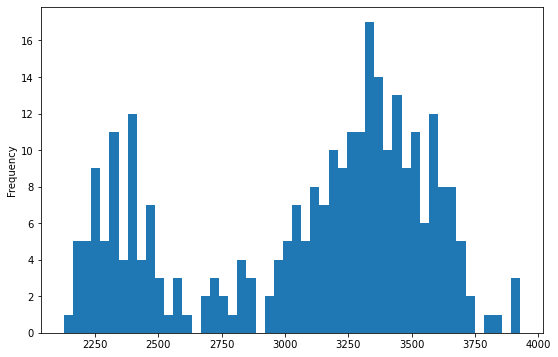

In [121]:
dataset_1.groupby('year-month')['year-month'].count().sort_values().plot(kind='hist', bins=50, figsize=(9,6));

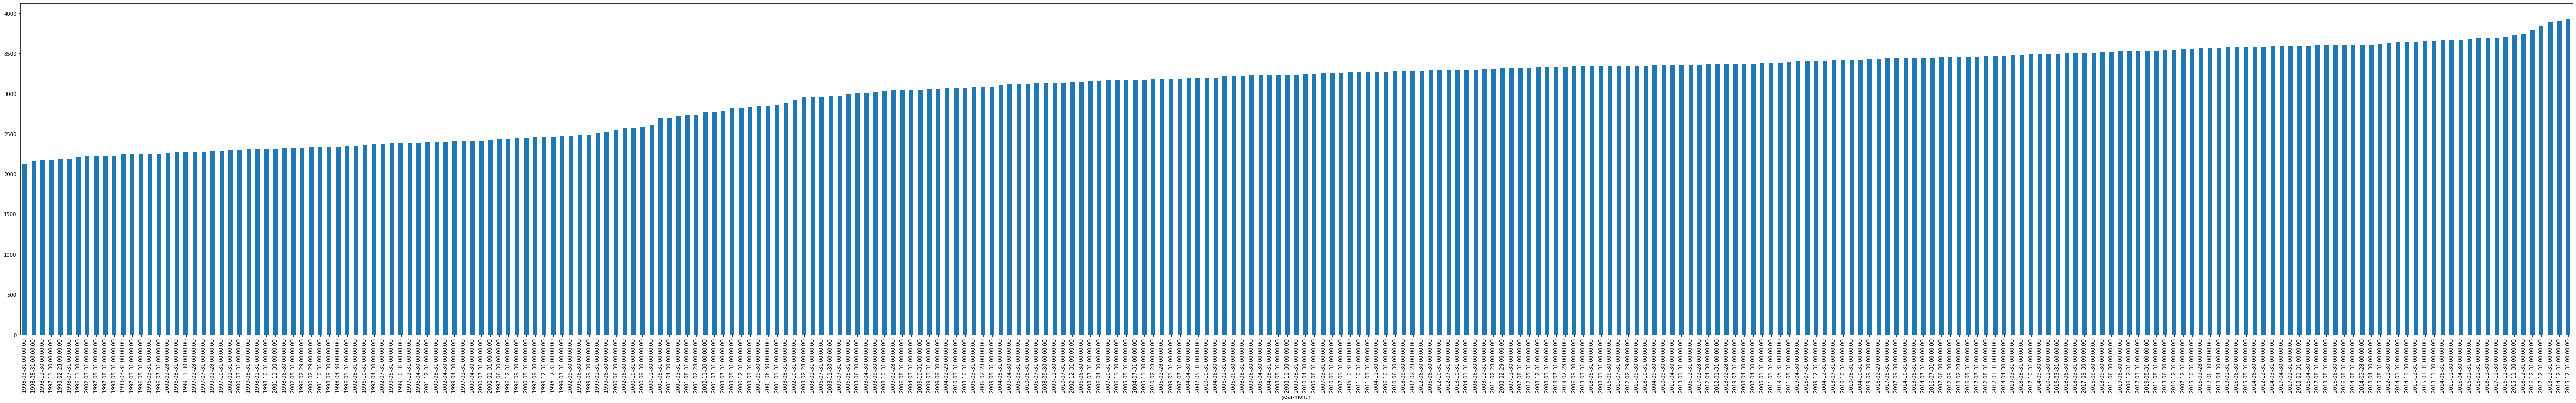

In [122]:
dataset_1.groupby('year-month')['year-month'].count().sort_values().plot(kind='bar', figsize=(90,12));

In [123]:
dataset_1.head()

,year-month,YEAR,QUARTER,MONTH,PASSENGERS,FREIGHT,MAIL,DISTANCE,jet_fuel_price_per_gallon_usd,UNIQUE_CARRIER_NAME,fare,market_city,ORIGIN,DEST,ORIGIN_CITY_NAME,DEST_CITY_NAME,ORIGIN_STATE_ABR,DEST_STATE_ABR,market_air
0,1999-02-28,1999,1,2,0.0,0.0,0.0,1199.0,0.309,World Airways Inc.,215.56,"Atlanta, GA - Denver, CO",ATL,DEN,"Atlanta, GA","Denver, CO",GA,CO,ATL - DEN
1,1999-02-28,1999,1,2,0.0,410.0,0.0,1747.0,0.309,Frontier Airlines Inc.,231.26,"Atlanta, GA - Las Vegas, NV",ATL,LAS,"Atlanta, GA","Las Vegas, NV",GA,NV,ATL - LAS
2,1999-02-28,1999,1,2,0.0,2692.0,240.0,1946.0,0.309,Frontier Airlines Inc.,328.40,"Atlanta, GA - Los Angeles, CA",ATL,LAX,"Atlanta, GA","Los Angeles, CA",GA,CA,ATL - LAX
3,1999-02-28,1999,1,2,0.0,0.0,0.0,481.0,0.309,United Air Lines Inc.,152.85,"Atlanta, GA - Richmond, VA",ATL,RIC,"Atlanta, GA","Richmond, VA",GA,VA,ATL - RIC
4,1999-02-28,1999,1,2,0.0,1632.0,0.0,2139.0,0.309,Frontier Airlines Inc.,379.22,"Atlanta, GA - San Francisco, CA",ATL,SFO,"Atlanta, GA","San Francisco, CA",GA,CA,ATL - SFO


In [124]:
# of unique routes
print(f'# of Routes: {len(dataset_1.market_air.unique())}')
print('---------------------------------')

# of states
print(f'# of States: {len(set(dataset_1.ORIGIN_STATE_ABR.unique() + dataset_1.DEST_STATE_ABR.unique()))}')
print('---------------------------------')

# of carriers
print(f'# of Carriers: {len(dataset_1.UNIQUE_CARRIER_NAME.unique())}')
print('---------------------------------')

# Longest Route / Market
print('LONGEST ROUTE')
print(str(dataset_1[dataset_1.DISTANCE == dataset_1.DISTANCE.max()].UNIQUE_CARRIER_NAME.unique()))
print(dataset_1[dataset_1.DISTANCE == dataset_1.DISTANCE.max()].market_air.unique())
print(dataset_1[dataset_1.DISTANCE == dataset_1.DISTANCE.max()].market_city.unique())
print(f'Route Distance: {dataset_1.DISTANCE.max()}')
print('---------------------------------')

# Shortest Route / Market
print('SHORTEST ROUTE')
print(str(dataset_1[dataset_1.DISTANCE == dataset_1.DISTANCE.min()].UNIQUE_CARRIER_NAME.unique()))
print(dataset_1[dataset_1.DISTANCE == dataset_1.DISTANCE.min()].market_air.unique())
print(dataset_1[dataset_1.DISTANCE == dataset_1.DISTANCE.min()].market_city.unique())
print(f'Route Distance: {dataset_1.DISTANCE.min()}')

# Most Flown Route (total passengers)

# of Routes: 3020
---------------------------------
# of States: 42
---------------------------------
# of Carriers: 206
---------------------------------
LONGEST ROUTE
['Miami Air International' 'Arrow Air Inc.']
['MIA - BFI']
['Miami, FL - Seattle, WA']
Route Distance: 2726.0
---------------------------------
SHORTEST ROUTE
['Trans World Airways LLC' 'Delta Air Lines Inc.' 'Envoy Air'
 'Trans States Airlines' 'United Air Lines Inc.' 'Flagship Airlines Inc.']
['JFK - PHL']
['New York, NY - Philadelphia, PA']
Route Distance: 94.0


In [125]:
# Most traveled route
print('MOST TRAVELED ROUTE')
print('Route Cities: ' + dataset_1.groupby('market_air')[['PASSENGERS']].sum().sort_values(by='PASSENGERS', ascending=False).head(1).index[0])
print('Route Distance: ' + dataset_1.groupby('market_city')[['PASSENGERS']].sum().sort_values(by='PASSENGERS', ascending=False).head(1).index[0])
print('Route Distance: ' + str(dataset_1[dataset_1['market_city'] == 'New York, NY - Philadelphia, PA']['DISTANCE'].max()))
print('Average Fare: $' + str(round(dataset_1[dataset_1['market_city'] == 'New York, NY - Philadelphia, PA']['fare'].mean(), 2)))
print('---------------------------------')

# Least traveled route
print('LEAST TRAVELED ROUTE')
print('Route Airports: ' + dataset_1.groupby('market_air')[['PASSENGERS']].sum().sort_values(by='PASSENGERS', ascending=False).tail(1).index[0])
print('Route Cities: ' + dataset_1.groupby('market_city')[['PASSENGERS']].sum().sort_values(by='PASSENGERS', ascending=False).tail(1).index[0])
print('Route Distance: ' + str(dataset_1[dataset_1['market_city'] == 'Detroit, MI - Greenville, NC']['DISTANCE'].min()))
print('Average Fare: $' + str(round(dataset_1[dataset_1['market_city'] == 'Detroit, MI - Greenville, NC']['fare'].mean(), 2)))

MOST TRAVELED ROUTE
Route Cities: LAX - SFO
Route Distance: Chicago, IL - New York, NY
Route Distance: 96.0
Average Fare: $160.32
---------------------------------
LEAST TRAVELED ROUTE
Route Airports: DET - MCI
Route Cities: Detroit, MI - Greenville, NC
Route Distance: 563.0
Average Fare: $327.14


In [126]:
dataset_1.columns

Index(['year-month', 'YEAR', 'QUARTER', 'MONTH', 'PASSENGERS', 'FREIGHT',
       'MAIL', 'DISTANCE', 'jet_fuel_price_per_gallon_usd',
       'UNIQUE_CARRIER_NAME', 'fare', 'market_city', 'ORIGIN', 'DEST',
       'ORIGIN_CITY_NAME', 'DEST_CITY_NAME', 'ORIGIN_STATE_ABR',
       'DEST_STATE_ABR', 'market_air'],
      dtype='object')

In [127]:
# Feature Engineer 1
dataset_1['passenger_miles'] = dataset_1['PASSENGERS'] * dataset_1['DISTANCE']

In [128]:
dataset_1.columns

Index(['year-month', 'YEAR', 'QUARTER', 'MONTH', 'PASSENGERS', 'FREIGHT',
       'MAIL', 'DISTANCE', 'jet_fuel_price_per_gallon_usd',
       'UNIQUE_CARRIER_NAME', 'fare', 'market_city', 'ORIGIN', 'DEST',
       'ORIGIN_CITY_NAME', 'DEST_CITY_NAME', 'ORIGIN_STATE_ABR',
       'DEST_STATE_ABR', 'market_air', 'passenger_miles'],
      dtype='object')

In [129]:
# Feature Engineer 2
dataset_1['distance_x_fuelprice'] = dataset_1['DISTANCE'] * dataset_1['jet_fuel_price_per_gallon_usd']

In [130]:
# Feature Engineer 3
dataset_1['passenger_revenue'] = dataset_1['fare'] * dataset_1['PASSENGERS']

In [131]:
dataset_1.head()

,year-month,YEAR,QUARTER,MONTH,PASSENGERS,FREIGHT,MAIL,DISTANCE,jet_fuel_price_per_gallon_usd,UNIQUE_CARRIER_NAME,...,ORIGIN,DEST,ORIGIN_CITY_NAME,DEST_CITY_NAME,ORIGIN_STATE_ABR,DEST_STATE_ABR,market_air,passenger_miles,distance_x_fuelprice,passenger_revenue
0,1999-02-28,1999,1,2,0.0,0.0,0.0,1199.0,0.309,World Airways Inc.,...,ATL,DEN,"Atlanta, GA","Denver, CO",GA,CO,ATL - DEN,0.0,370.491,0.0
1,1999-02-28,1999,1,2,0.0,410.0,0.0,1747.0,0.309,Frontier Airlines Inc.,...,ATL,LAS,"Atlanta, GA","Las Vegas, NV",GA,NV,ATL - LAS,0.0,539.823,0.0
2,1999-02-28,1999,1,2,0.0,2692.0,240.0,1946.0,0.309,Frontier Airlines Inc.,...,ATL,LAX,"Atlanta, GA","Los Angeles, CA",GA,CA,ATL - LAX,0.0,601.314,0.0
3,1999-02-28,1999,1,2,0.0,0.0,0.0,481.0,0.309,United Air Lines Inc.,...,ATL,RIC,"Atlanta, GA","Richmond, VA",GA,VA,ATL - RIC,0.0,148.629,0.0
4,1999-02-28,1999,1,2,0.0,1632.0,0.0,2139.0,0.309,Frontier Airlines Inc.,...,ATL,SFO,"Atlanta, GA","San Francisco, CA",GA,CA,ATL - SFO,0.0,660.951,0.0


In [132]:
# Set index as datetime
dataset_1.set_index('year-month', inplace=True)

In [133]:
# Sort index to ascending
dataset_1.sort_index(inplace=True)

In [134]:
# Data goes by month - JANUARY 1996 - SEPTEMBER 2019
sorted(dataset_1.index.unique())[:5]

[Timestamp('1996-01-31 00:00:00'),
 Timestamp('1996-02-29 00:00:00'),
 Timestamp('1996-03-31 00:00:00'),
 Timestamp('1996-04-30 00:00:00'),
 Timestamp('1996-05-31 00:00:00')]

In [135]:
# EDA on last full completed year of data 2018
dataset_1.head()

,YEAR,QUARTER,MONTH,PASSENGERS,FREIGHT,MAIL,DISTANCE,jet_fuel_price_per_gallon_usd,UNIQUE_CARRIER_NAME,fare,...,ORIGIN,DEST,ORIGIN_CITY_NAME,DEST_CITY_NAME,ORIGIN_STATE_ABR,DEST_STATE_ABR,market_air,passenger_miles,distance_x_fuelprice,passenger_revenue
year-month,,,,,,,,,,,,,,,,,,,,,
1996-01-31,1996,1,1,4792.0,11368.0,7265.0,201.0,0.55,ExpressJet Airlines Inc.,82.14,...,CRP,IAH,"Corpus Christi, TX","Houston, TX",TX,TX,CRP - IAH,963192.0,110.55,393614.88
1996-01-31,1996,1,1,2943.0,12306.0,4888.0,562.0,0.55,American Airlines Inc.,116.68,...,BNA,DCA,"Nashville, TN","Washington, DC",TN,VA,BNA - DCA,1653966.0,309.10,343389.24
1996-01-31,1996,1,1,16667.0,37092.0,72204.0,727.0,0.55,US Airways Inc.,270.50,...,BOS,CLT,"Boston, MA","Charlotte, NC",MA,NC,BOS - CLT,12116909.0,399.85,4508423.50
1996-01-31,1996,1,1,2959.0,7383.0,0.0,1185.0,0.55,Western Pacific Airlines,118.93,...,ATL,COS,"Atlanta, GA","Colorado Springs, CO",GA,CO,ATL - COS,3506415.0,651.75,351913.87
1996-01-31,1996,1,1,95.0,344.0,0.0,1097.0,0.55,Continental Air Lines Inc.,137.68,...,MIA,LGA,"Miami, FL","New York, NY",FL,NY,MIA - LGA,104215.0,603.35,13079.60


In [151]:
d2018 = dataset_1['2018']
d2018.groupby(['market_city', 'market_air']).agg({'passenger_revenue' : sum}).sort_values(by='passenger_revenue', ascending=False)[:20]

,,passenger_revenue
market_city,market_air,
"Los Angeles, CA - New York, NY",LAX - JFK,6.366743e+08
"New York, NY - San Francisco, CA",JFK - SFO,3.625955e+08
"Chicago, IL - Los Angeles, CA",ORD - LAX,3.184135e+08
"Atlanta, GA - Los Angeles, CA",ATL - LAX,3.063508e+08
"Chicago, IL - New York, NY",ORD - LGA,2.953342e+08
"Chicago, IL - San Francisco, CA",ORD - SFO,2.936225e+08
"Los Angeles, CA - San Francisco, CA",LAX - SFO,2.505688e+08
"Atlanta, GA - New York, NY",ATL - LGA,2.467702e+08
"Dallas/Fort Worth, TX - Los Angeles, CA",DFW - LAX,2.336182e+08


In [150]:
d2018.columns

Index(['YEAR', 'QUARTER', 'MONTH', 'PASSENGERS', 'FREIGHT', 'MAIL', 'DISTANCE',
       'jet_fuel_price_per_gallon_usd', 'UNIQUE_CARRIER_NAME', 'fare',
       'market_city', 'ORIGIN', 'DEST', 'ORIGIN_CITY_NAME', 'DEST_CITY_NAME',
       'ORIGIN_STATE_ABR', 'DEST_STATE_ABR', 'market_air', 'passenger_miles',
       'distance_x_fuelprice', 'passenger_revenue'],
      dtype='object')

In [152]:
d2018[(d2018['market_air'] == 'LAX - JFK')]

,YEAR,QUARTER,MONTH,PASSENGERS,FREIGHT,MAIL,DISTANCE,jet_fuel_price_per_gallon_usd,UNIQUE_CARRIER_NAME,fare,...,ORIGIN,DEST,ORIGIN_CITY_NAME,DEST_CITY_NAME,ORIGIN_STATE_ABR,DEST_STATE_ABR,market_air,passenger_miles,distance_x_fuelprice,passenger_revenue
year-month,,,,,,,,,,,,,,,,,,,,,
2018-01-31,2018,1,1,20058.0,0.0,0.0,2475.0,1.952,Virgin America,366.30,...,LAX,JFK,"Los Angeles, CA","New York, NY",CA,NY,LAX - JFK,49643550.0,4831.200,7347245.40
2018-01-31,2018,1,1,43235.0,2021235.0,504789.0,2475.0,1.952,Delta Air Lines Inc.,366.30,...,LAX,JFK,"Los Angeles, CA","New York, NY",CA,NY,LAX - JFK,107006625.0,4831.200,15836980.50
2018-01-31,2018,1,1,38802.0,0.0,0.0,2475.0,1.952,JetBlue Airways,366.30,...,LAX,JFK,"Los Angeles, CA","New York, NY",CA,NY,LAX - JFK,96034950.0,4831.200,14213172.60
2018-01-31,2018,1,1,0.0,0.0,36652.0,2475.0,1.952,Kalitta Air LLC,366.30,...,LAX,JFK,"Los Angeles, CA","New York, NY",CA,NY,LAX - JFK,0.0,4831.200,0.00
2018-01-31,2018,1,1,28043.0,193741.0,216430.0,2475.0,1.952,American Airlines Inc.,366.30,...,LAX,JFK,"Los Angeles, CA","New York, NY",CA,NY,LAX - JFK,69406425.0,4831.200,10272150.90
2018-02-28,2018,1,2,26922.0,165227.0,153420.0,2475.0,1.849,American Airlines Inc.,366.30,...,LAX,JFK,"Los Angeles, CA","New York, NY",CA,NY,LAX - JFK,66631950.0,4576.275,9861528.60
2018-02-28,2018,1,2,19683.0,0.0,0.0,2475.0,1.849,Virgin America,366.30,...,LAX,JFK,"Los Angeles, CA","New York, NY",CA,NY,LAX - JFK,48715425.0,4576.275,7209882.90
2018-02-28,2018,1,2,36669.0,0.0,0.0,2475.0,1.849,JetBlue Airways,366.30,...,LAX,JFK,"Los Angeles, CA","New York, NY",CA,NY,LAX - JFK,90755775.0,4576.275,13431854.70
2018-02-28,2018,1,2,41051.0,2316443.0,506043.0,2475.0,1.849,Delta Air Lines Inc.,366.30,...,LAX,JFK,"Los Angeles, CA","New York, NY",CA,NY,LAX - JFK,101601225.0,4576.275,15036981.30


In [154]:
d2018[(d2018['market_air'] == 'LAX - JFK')].UNIQUE_CARRIER_NAME.unique()

array(['Virgin America', 'Delta Air Lines Inc.', 'JetBlue Airways',
       'Kalitta Air LLC', 'American Airlines Inc.',
       'Alaska Airlines Inc.', 'Atlas Air Inc.',
       'Jet Aviation Flight Services, Inc.', 'Amerijet International'],
      dtype=object)